In [11]:
import torch
import numpy as np
from typing import List
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
NUM_CLASSES = 29
LABELS = [chr(i) for i in range(65, 91)] + ["SPACE", "DELETE", "NOTHING"]

In [2]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=29):
        super(ConvNet, self).__init__()
        
        # 1st convolution layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        # 2nd convolution layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        # 3rd convolution layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.bn1(x)
        
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.bn2(x)
        
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.bn3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [6]:
# Path to the model file
import os
project_dir = Path(os.path.abspath('')).resolve().parent
model_path = project_dir / "model" / "asl_model.pth"

if not model_path.is_file():
    raise FileNotFoundError(f"Model file not found at: {model_path}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\amine\AppData\Local\Temp\ipykernel_25804\2730502007.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=29, bias=True)
)

In [7]:
# Function to load the entire dataset from a CSV file and create a DataLoader
def load_dataloader_from_csv(csv_file, batch_size=128, img_shape=(1, 32, 32)):
    df = pd.read_csv(csv_file)

    # Separate the features (image data) and labels
    labels = df['label'].values
    features = df.drop(columns=['label']).values

    # Reshape the features back into the original image shape
    features = features.reshape(-1, *img_shape)

    # Convert to PyTorch tensors
    data_tensors = torch.tensor(features, dtype=torch.float32)
    label_tensors = torch.tensor(labels, dtype=torch.long)

    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(data_tensors, label_tensors)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return data_loader

In [12]:
DATA_PATH = '../dataset/'

val_loader = load_dataloader_from_csv(f"{DATA_PATH}val.csv", batch_size=128)
test_loader = load_dataloader_from_csv(f"{DATA_PATH}test.csv", batch_size=128)

# Example: Iterate over the test_loader
for batch_idx, (data, labels) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Batch 1:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 2:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 3:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 4:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 5:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 6:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 7:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 8:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 9:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 10:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 11:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 12:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
B

In [14]:
model.to(device)

# Evaluate the model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, labels in test_loader:
        # Move data and labels to the same device as the model
        data, labels = data.to(device), labels.to(device)

        # Forward pass
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)

        # Collect predictions and true labels (move to CPU for metrics)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [15]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=LABELS))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 95.64%
Precision: 0.96, Recall: 0.96, F1-score: 0.96

Classification Report:
              precision    recall  f1-score   support

           A       0.91      0.92      0.92       300
           B       0.91      0.94      0.92       300
           C       0.99      0.98      0.98       300
           D       0.95      0.99      0.97       300
           E       0.99      0.85      0.91       300
           F       1.00      0.96      0.98       300
           G       0.94      0.97      0.95       300
           H       0.99      0.94      0.96       300
           I       0.99      0.93      0.96       300
           J       1.00      0.90      0.95       300
           K       0.95      0.98      0.96       300
           L       0.98      1.00      0.99       300
           M       0.88      0.98      0.93       300
           N       0.95      0.93      0.94       300
           O       1.00      0.95      0.98       300
           P       0.99      0.97      0.98     

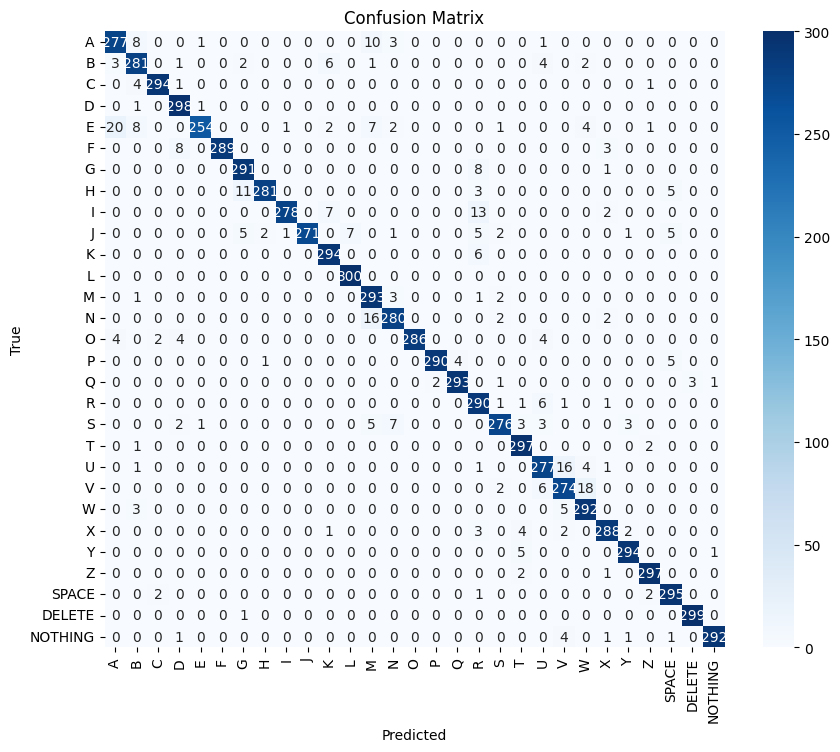

In [16]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

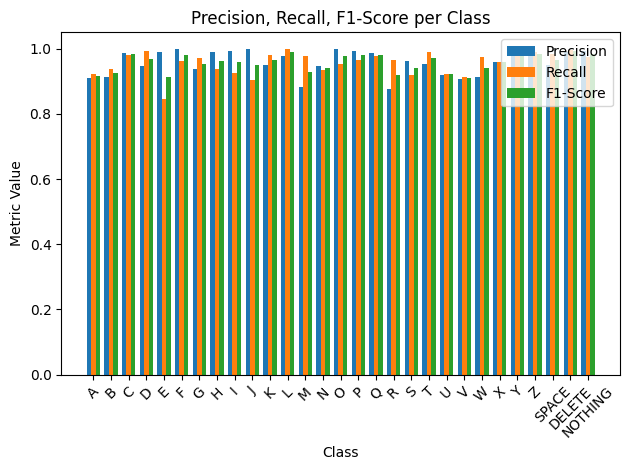

In [17]:
# Precision, recall, and F1-score for each class
class_metrics = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(LABELS)))
precision_per_class, recall_per_class, f1_per_class = class_metrics[:3]

# Plot metrics per class
x = np.arange(len(LABELS))
width = 0.25

plt.bar(x - width, precision_per_class, width=width, label='Precision')
plt.bar(x, recall_per_class, width=width, label='Recall')
plt.bar(x + width, f1_per_class, width=width, label='F1-Score')

plt.xticks(x, LABELS, rotation=45)
plt.xlabel('Class')
plt.ylabel('Metric Value')
plt.title('Precision, Recall, F1-Score per Class')
plt.legend()
plt.tight_layout()
plt.show()
